In [1]:
from os import listdir
import numpy as np
import pandas as pd
import string
from nltk.translate.bleu_score import corpus_bleu
from pickle import load, dump
from IPython.display import Image
 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model, to_categorical
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM
from keras.layers import RepeatVector, TimeDistributed
from keras.layers import Embedding
from keras.layers.merge import concatenate
from keras.layers.pooling import GlobalMaxPooling2D

import caption_generation_model_API as cgm
from caption_generation_model_API import *

Using TensorFlow backend.


# Network Size Parameters
In this section, we will see how gross variations to the network structure impact model skill.

We will look at the following aspects of the model size:

* Size of the fixed-vector output from the ‘encoders’.
* Size of the sequence encoder model.
* Size of the language model.
Let’s dive in.

## Size of Fixed-Length Vector
In the baseline model, the photo feature extractor and the text sequence encoder both output a 128 element vector. These vectors are then concatenated to be processed by the language model.

The 128 element vector from each sub-model contains everything known about the input sequence and photo. We can vary the size of this vector to see if it impacts model skill

First, we can decrease the size by half from 128 elements to 64 elements.

In [2]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(64, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(64, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_sm_fixed_vec_plot.png')
    
    return model

In [3]:
path = 'D:/Program/dataset/Flickr8K/'

# load dev set
filename = path + 'Flickr8k_text/Flickr_8k.devImages.txt'
dataset = load_set(filename)
print('Dataset: {}'.format(len(dataset)))
# train-test split
train, test = train_test_split(dataset)
# descriptions
train_descriptions = load_clean_descriptions(path+'descriptions.txt', train)
test_descriptions = load_clean_descriptions(path+'descriptions.txt', test)
print('Descriptions: train={}, test={}'.format(len(train_descriptions), len(test_descriptions)))
# photo features
train_features = load_photo_features(path+'features.pkl', train)
test_features = load_photo_features(path+'features.pkl', test)
print('Photos: train={}, test={}'.format(len(train_features), len(test_features)))
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(vocab_size))
# determine the maximum sequence length
max_length = max(len(s.split()) for s in list(train_descriptions.values()))
print('Description Length: {}'.format(max_length))

Dataset: 1000
Descriptions: train=100, test=100
Photos: train=100, test=100
Vocabulary Size: 366
Description Length: 25


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_1 (GlobalM (None, 512)          0           input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 25, 50)       18300       input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (D

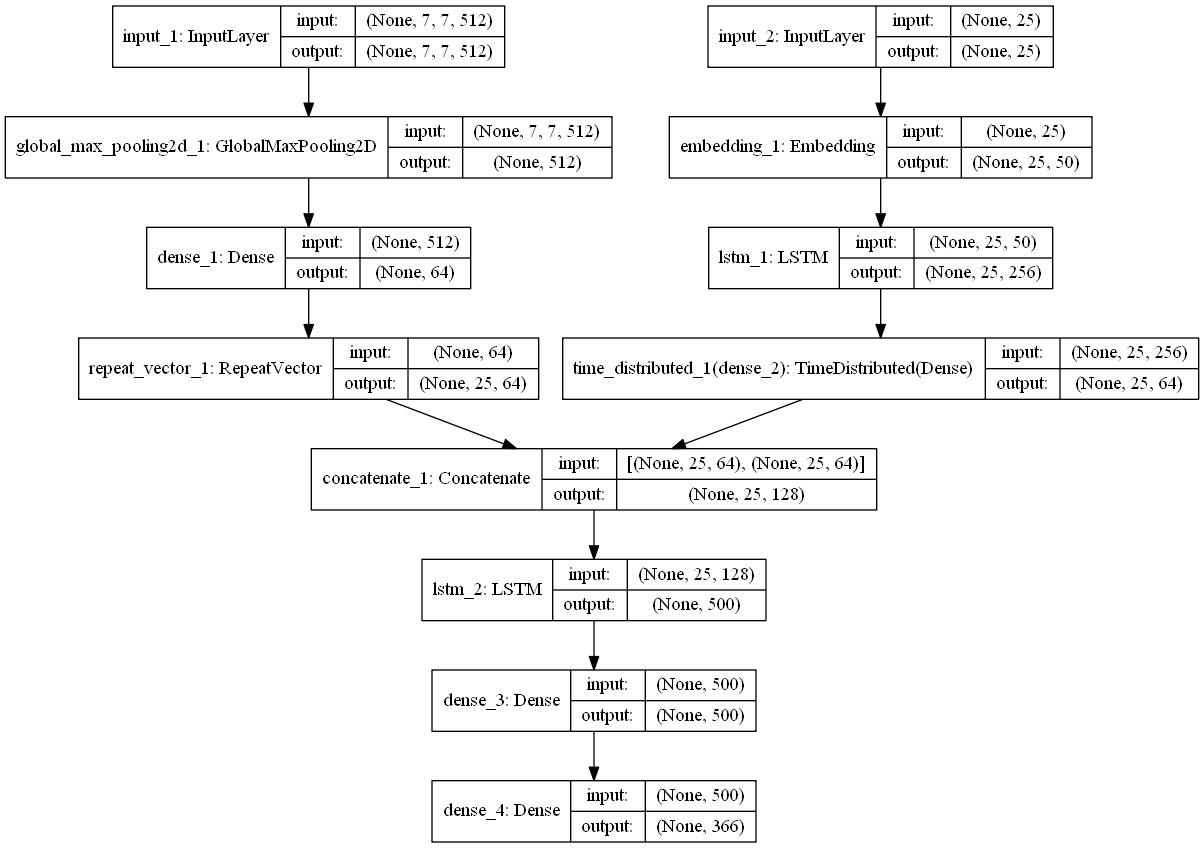

In [4]:
# define experiment
model_name = 'size_sm_fixed_vec'
verbose = 2
n_epochs = 50
n_photos_per_update = 2
n_batches_per_epoch = int(len(train) / n_photos_per_update)
n_repeats = 3
 
model = define_model(vocab_size, max_length)
Image('size_sm_fixed_vec_plot.png')

In [5]:
# run experiment
train_results, test_results = list(), list()
for i in range(n_repeats):
    # define the model
    model = define_model(vocab_size, max_length)
    # fit model
    model.fit_generator(data_generator(train_descriptions, train_features, 
                                       tokenizer, max_length, n_photos_per_update), 
                        steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
    # evaluate model on training data
    train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
    test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
    # store
    train_results.append(train_score)
    test_results.append(test_score)
    print('>{}: train={} test={}'.format((i+1), train_score, test_score))


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_2 (GlobalM (None, 512)          0           input_3[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 25, 50)       18300       input_4[0][0]                    
__________________________________________________________________________________________________
dense_5 (D

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.16638636862572426 test=0.05702926063627223
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_3 (GlobalM (None, 512)          0           input_5[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 25, 50)       18300       input_6[0][0]                    
______________________________________________________

Epoch 1/50
 - 19s - loss: 5.4290 - acc: 0.0892
Epoch 2/50
 - 18s - loss: 5.1067 - acc: 0.1048
Epoch 3/50
 - 17s - loss: 5.0501 - acc: 0.1042
Epoch 4/50
 - 17s - loss: 4.9922 - acc: 0.1058
Epoch 5/50
 - 17s - loss: 4.9518 - acc: 0.1056
Epoch 6/50
 - 17s - loss: 4.9247 - acc: 0.1116
Epoch 7/50
 - 18s - loss: 4.9091 - acc: 0.1141
Epoch 8/50
 - 18s - loss: 4.7674 - acc: 0.1231
Epoch 9/50
 - 18s - loss: 4.6922 - acc: 0.1295
Epoch 10/50
 - 17s - loss: 4.5967 - acc: 0.1394
Epoch 11/50
 - 17s - loss: 4.4422 - acc: 0.1498
Epoch 12/50
 - 17s - loss: 4.3360 - acc: 0.1497
Epoch 13/50
 - 17s - loss: 4.2145 - acc: 0.1541
Epoch 14/50
 - 18s - loss: 4.1240 - acc: 0.1528
Epoch 15/50
 - 17s - loss: 3.9883 - acc: 0.1608
Epoch 16/50
 - 17s - loss: 3.8161 - acc: 0.1612
Epoch 17/50
 - 17s - loss: 3.6929 - acc: 0.1760
Epoch 18/50
 - 17s - loss: 3.5848 - acc: 0.1893
Epoch 19/50
 - 17s - loss: 3.4257 - acc: 0.1873
Epoch 20/50
 - 17s - loss: 3.2650 - acc: 0.2039
Epoch 21/50
 - 17s - loss: 3.1563 - acc: 0.2094
E

In [7]:
# save results to file
df = pd.DataFrame()
df['train'] = train_results
df['test'] = test_results
print(df.describe())
df.to_csv(path+model_name+'.csv', index=False)

          train      test
count  3.000000  3.000000
mean   0.170598  0.046878
std    0.065469  0.013448
min    0.107336  0.031627
25%    0.136861  0.041803
50%    0.166386  0.051979
75%    0.202229  0.054504
max    0.238071  0.057029


In [10]:
def evaluate_and_print(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)
        # store actual and predicted
        actual.append([desc.split()])
        predicted.append(yhat.split())
        print('Actual:    {}'.format(desc))
        print('Predicted: {}'.format(yhat))
        print()
        if len(actual) >= 5:
            break
    # calculate BLEU score
    bleu = corpus_bleu(actual, predicted)
    return bleu

In [11]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq child and woman are are at edge edge big big big big big big big big big big big big big big big big big

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq boy boy stick stick stick front front front goalie net endseq

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq woman crouches crouches dogs dogs in in in in in in in in in in in in in in in in in in in in

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq boy boy hard hard treat sits sits sits sits sits sits sits sits outside endseq

Actual:    startseq person eats takeout while watching small television endseq
Predicted: startseq person eats eats watching watching small television endseq



0.141340637106256

In [12]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq man and and and and and and and and and and and and and and and and and and and and and and and and

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq young boy young young young young young young young young young young young young young young young young young young young young young young young

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq child young young young young young young young young young young young young young young young young young young young young young young young young

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq child young child is is is is is is is is is is is is is is is is is is is is is is

Actual:    startseq man in green hat is someplace up high endseq
Predicted: startseq gi

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.49779244057305255

---
We can also double the size of the fixed-length vector from 128 to 256 units.

In [16]:
n_repeats = 1
model_name = 'size_lg_fixed_vec'

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_6 (GlobalM (None, 512)          0           input_11[0][0]                   
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 25, 50)       18300       input_12[0][0]                   
__________________________________________________________________________________________________
dense_21 (

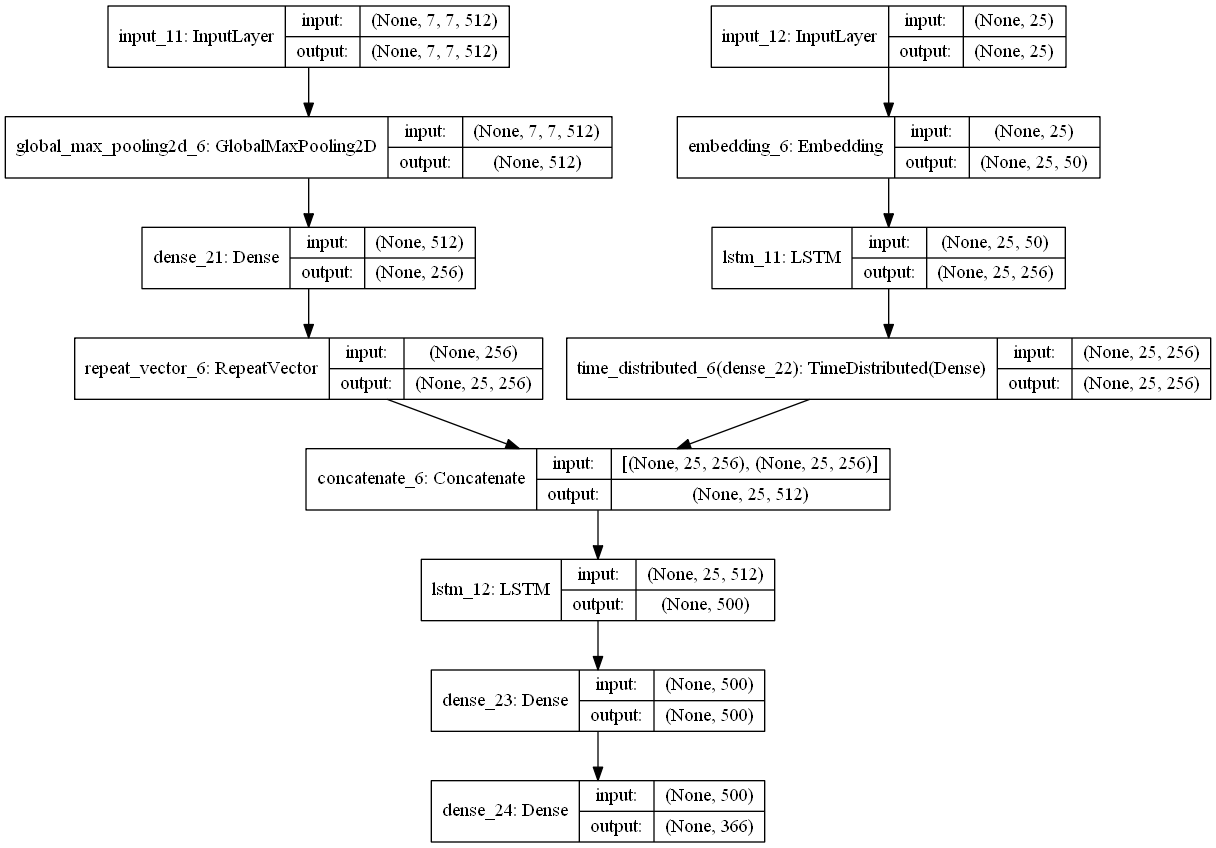

In [17]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(256, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_lg_fixed_vec_plot.png')
    
    return model

model = define_model(vocab_size, max_length)
Image('size_lg_fixed_vec_plot.png')

In [21]:
def run_experiment():
    # run experiment
    train_results, test_results = list(), list()
    for i in range(n_repeats):
        # define the model
        model = define_model(vocab_size, max_length)
        # fit model
        model.fit_generator(data_generator(train_descriptions, train_features, 
                                           tokenizer, max_length, n_photos_per_update), 
                            steps_per_epoch=n_batches_per_epoch, epochs=n_epochs, verbose=verbose)
        # evaluate model on training data
        train_score = evaluate_model(model, train_descriptions, train_features, tokenizer, max_length)
        test_score = evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)
        # store
        train_results.append(train_score)
        test_results.append(test_score)
        print('>{}: train={} test={}'.format((i+1), train_score, test_score))
        
        return train_results, test_results

In [22]:
def save_res(train_results, test_results):
    # save results to file
    df = pd.DataFrame()
    df['train'] = train_results
    df['test'] = test_results
    print(df.describe())
    df.to_csv(path+model_name+'.csv', index=False)

In [23]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_8 (GlobalM (None, 512)          0           input_15[0][0]                   
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 25, 50)       18300       input_16[0][0]                   
__________________________________________________________________________________________________
dense_29 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.06484797231505461 test=0.06378315690224845


In [24]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.064848  0.063783
std         NaN       NaN
min    0.064848  0.063783
25%    0.064848  0.063783
50%    0.064848  0.063783
75%    0.064848  0.063783
max    0.064848  0.063783


In [25]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq line line line line line line line line line line line line line line line line line line line line line line line line line

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful colorful

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq line line line line line line line line line line line line line line line line line line line line line line line line line

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq sand sand sand head head head head head head head head head head head head head head head head head head head head head head

Actual:    startseq person

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [26]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq trash scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing scrubbing

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq up up line line line line line line line line line line line line line line line line line line line line line line line

Actual:    startseq boy holding kitchen utensils and maki

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
Running this experiment shows BLEU scores suggesting that the model is not better off.

It is possible that with more data and/or longer training, we may see a different story.

## Sequence Encoder Size

We can call the sub-model that interprets the input sequence of words generated so far as the sequence encoder.

First, we can try to see if decreasing the representational capacity of the sequence encoder impacts model skill. We can reduce the number of memory units in the LSTM layer from 256 to 128.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_10 (Global (None, 512)          0           input_19[0][0]                   
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 25, 50)       18300       input_20[0][0]                   
__________________________________________________________________________________________________
dense_37 (

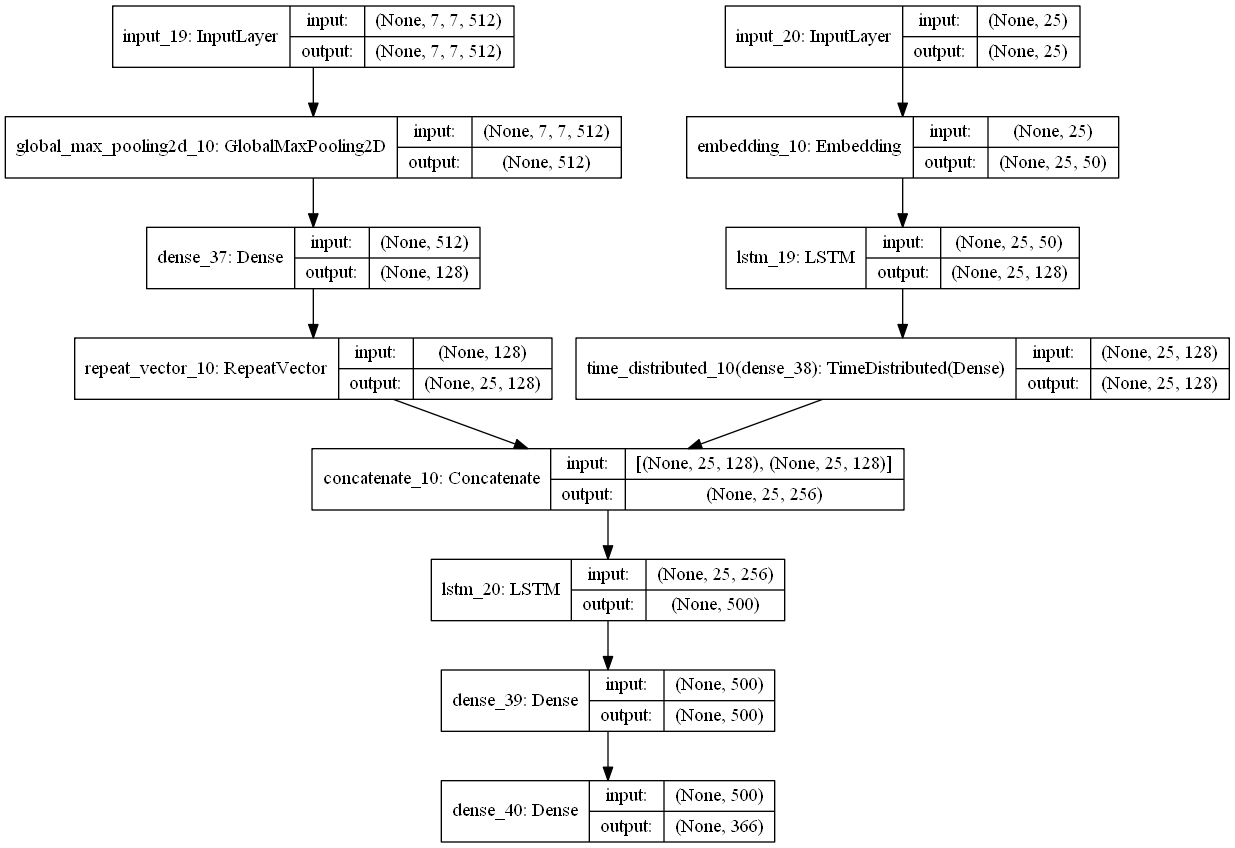

In [28]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(128, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_sm_seq_model_plot.png')
    
    return model
 
model_name = 'size_sm_seq_model'
model = define_model(vocab_size, max_length)
Image('size_sm_seq_model_plot.png')

In [29]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_11 (Global (None, 512)          0           input_21[0][0]                   
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 25, 50)       18300       input_22[0][0]                   
__________________________________________________________________________________________________
dense_41 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [30]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.068293  0.032144
std         NaN       NaN
min    0.068293  0.032144
25%    0.068293  0.032144
50%    0.068293  0.032144
75%    0.068293  0.032144
max    0.068293  0.032144


In [31]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute shute

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches caches

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq gear gear carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries carries

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq station caches caches caches caches caches caches caches caches caches caches caches caches caches caches ca

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [32]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq by by by by by by by by by by by by by by by by by by by by by by by by by

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq shirt gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear gear

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq rides rides rides rides rides rides rides two two two two two two two two two two two two two two two two two two

Actual:    startseq man in green hat is someplace up high endseq
Predicted: startseq winter winter winte

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
We can see perhaps a small bump on both train and test over baseline. This might be an artifact of the small training set size.

Going the other way, we can double the number of LSTM layers from one to two and see if that makes a dramatic difference.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_24 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
input_23 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 25, 50)       18300       input_24[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_12 (Global (None, 512)          0           input_23[0][0]                   
__________________________________________________________________________________________________
lstm_23 (L

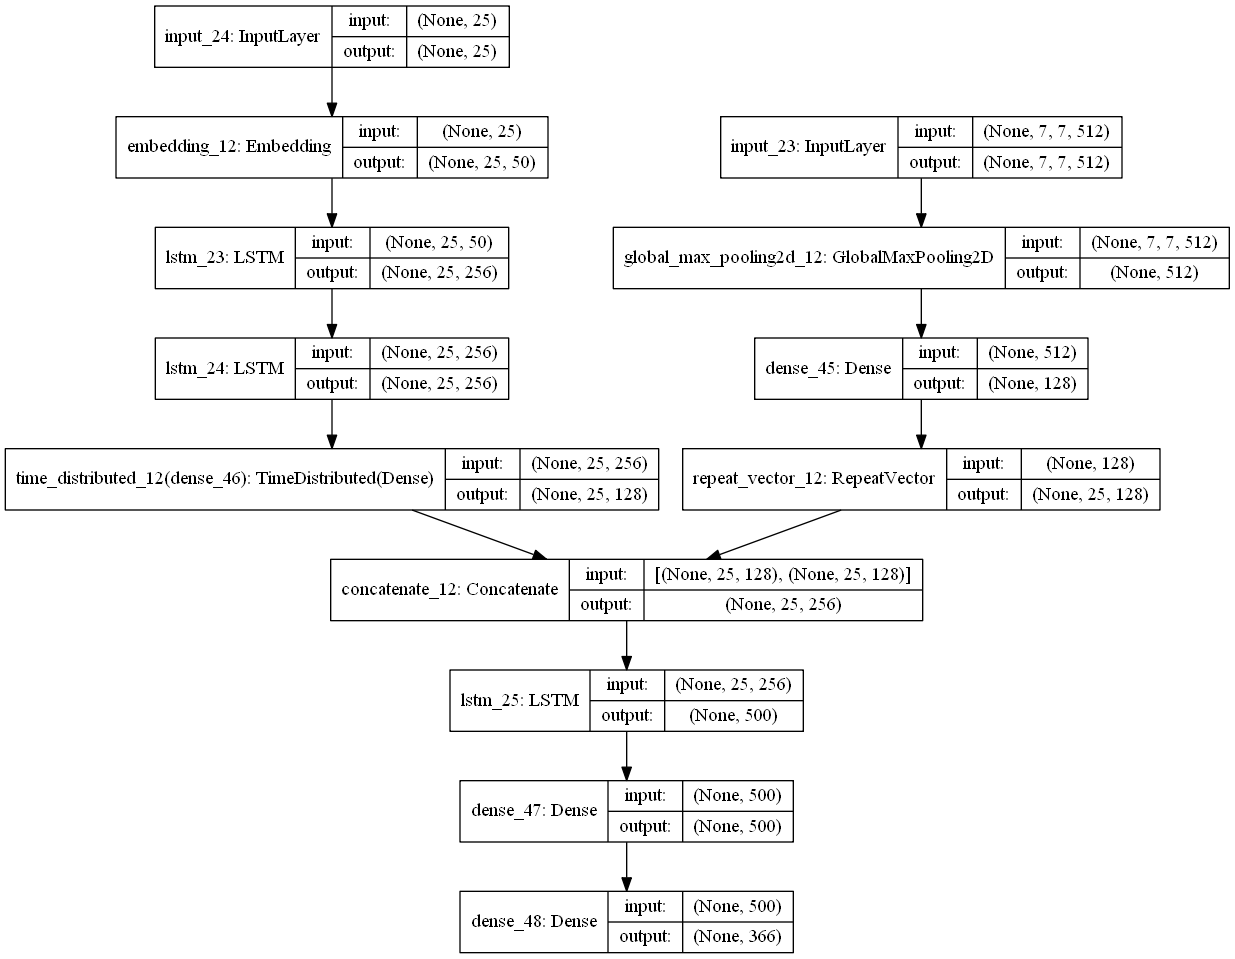

In [33]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = LSTM(256, return_sequences=True)(emb3)
    emb5 = TimeDistributed(Dense(128, activation='relu'))(emb4)
    # merge inputs
    merged = concatenate([fe3, emb5])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_lg_seq_model_plot.png')
    
    return model
 
model_name = 'size_lg_seq_model'
model = define_model(vocab_size, max_length)
Image('size_lg_seq_model_plot.png')

In [34]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
embedding_13 (Embedding)        (None, 25, 50)       18300       input_26[0][0]                   
__________________________________________________________________________________________________
global_max_pooling2d_13 (Global (None, 512)          0           input_25[0][0]                   
__________________________________________________________________________________________________
lstm_26 (L

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.02771906617941034 test=0.026077716148274664


In [35]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.027719  0.026078
std         NaN       NaN
min    0.027719  0.026078
25%    0.027719  0.026078
50%    0.027719  0.026078
75%    0.027719  0.026078
max    0.027719  0.026078


In [36]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq toddler station station station station station station station station station station station station station station station station station station station station station station station station

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq overgrown frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee frisbee

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq jacket jacket jacket casting casting casting casting casting casting cast

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [37]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq jacket jacket jacket jacket jacket stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone stone

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq has has has has has has has has has has has has has has has has has has has has has has has has has

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq station station station station station station station station station station station station station station station station station station station station stati

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
Running this experiment shows a decent bump in BLEU on both train and test sets.

We can also try to increase the representational capacity of the word embedding by doubling it from 50-dimensions to 100-dimensions.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_14 (Global (None, 512)          0           input_27[0][0]                   
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 25, 100)      36600       input_28[0][0]                   
__________________________________________________________________________________________________
dense_53 (

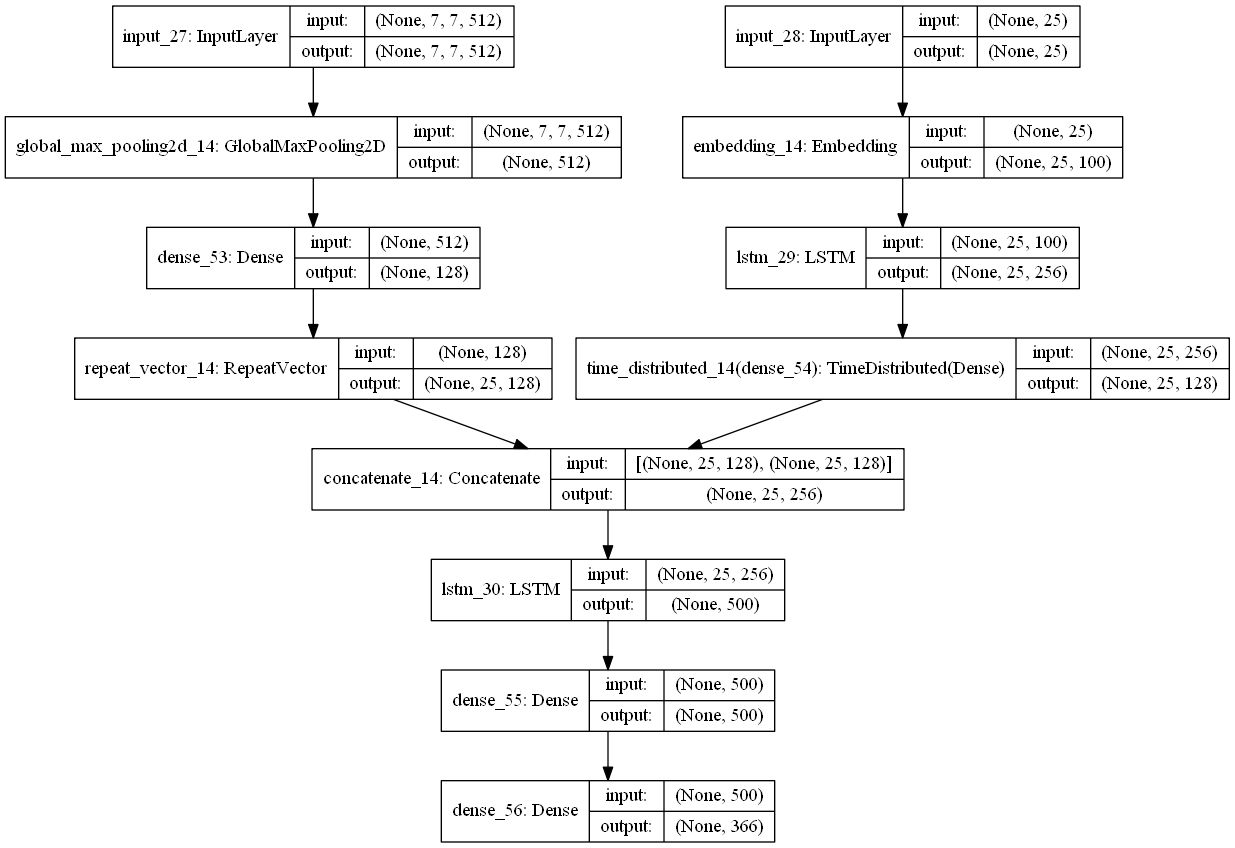

In [38]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 100, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500)(merged)
    lm3 = Dense(500, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_em_seq_model_plot.png')
    
    return model
 
model_name = 'size_em_seq_model'
model = define_model(vocab_size, max_length)
Image('size_em_seq_model_plot.png')

In [39]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_15 (Global (None, 512)          0           input_29[0][0]                   
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 25, 100)      36600       input_30[0][0]                   
__________________________________________________________________________________________________
dense_57 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.05633482977622931 test=0.03133471138265919


In [40]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.056335  0.031335
std         NaN       NaN
min    0.056335  0.031335
25%    0.056335  0.031335
50%    0.056335  0.031335
75%    0.056335  0.031335
max    0.056335  0.031335


In [41]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq formally formally formally formally formally formally formally formally formally formally formally formally formally formally formally formally formally formally formally goalie goalie goalie goalie goalie goalie

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq another another another another another another another another another another another another another another another another another another another another another another another another another

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks looks

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq table put put put put put put put put put put put put put put pu

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [42]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame frame

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword sword

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks walks 

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
We see a large movement on the training dataset, but perhaps little movement on the test dataset.

## Size of Language Model
We can refer to the model that learns from the concatenated sequence and photo feature input as the language model. It is responsible for generating words.

First, we can look at the impact on model skill by cutting the LSTM and dense layers from 500 to 256 neurons.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_16 (Global (None, 512)          0           input_31[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 25, 50)       18300       input_32[0][0]                   
__________________________________________________________________________________________________
dense_61 (

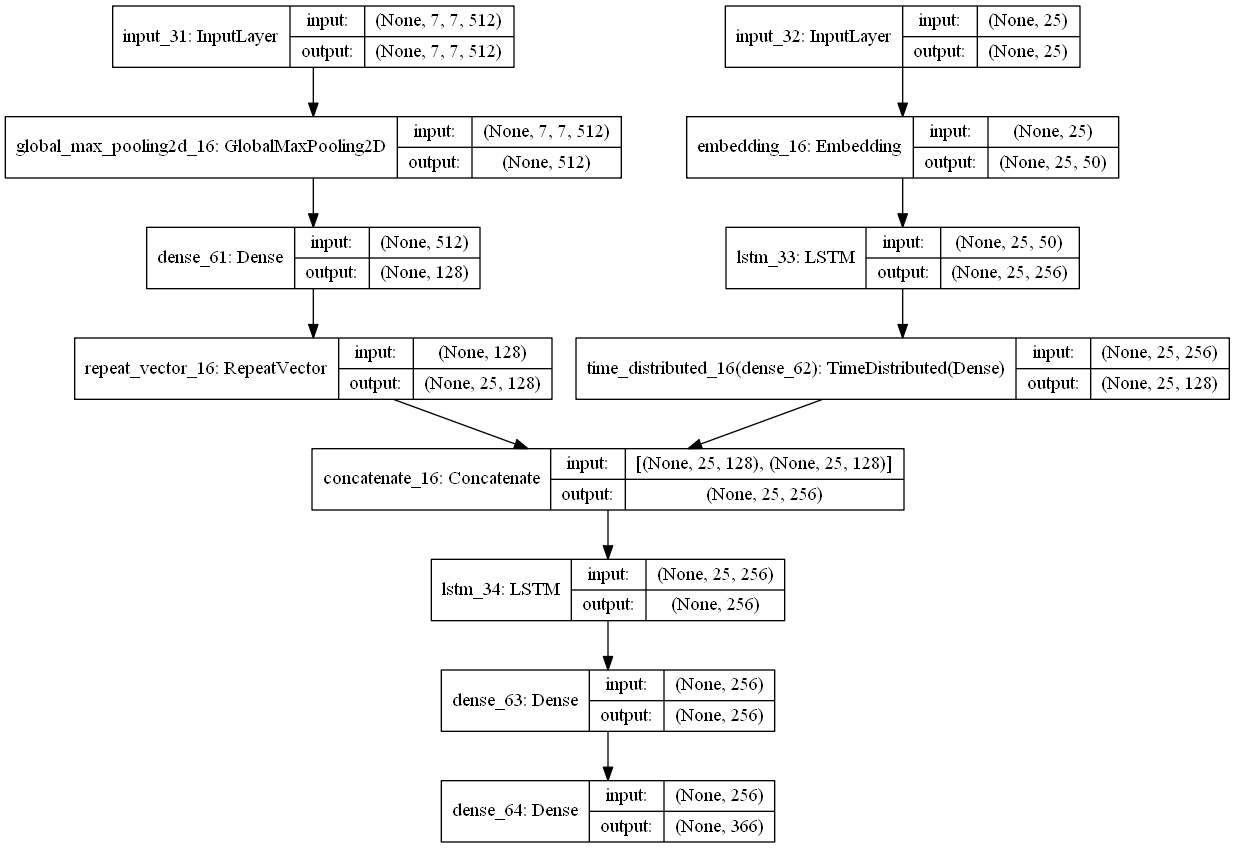

In [43]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(256)(merged)
    lm3 = Dense(256, activation='relu')(lm2)
    outputs = Dense(vocab_size, activation='softmax')(lm3)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_sm_lang_model_plot.png')
    
    return model
 
model_name = 'size_sm_lang_model'
model = define_model(vocab_size, max_length)
Image('size_sm_lang_model_plot.png')

In [44]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_17 (Global (None, 512)          0           input_33[0][0]                   
__________________________________________________________________________________________________
embedding_17 (Embedding)        (None, 25, 50)       18300       input_34[0][0]                   
__________________________________________________________________________________________________
dense_65 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.08476160499963555 test=0.0523572678954491


In [45]:
save_res(train_results, test_results)

          train      test
count  1.000000  1.000000
mean   0.084762  0.052357
std         NaN       NaN
min    0.084762  0.052357
25%    0.084762  0.052357
50%    0.084762  0.052357
75%    0.084762  0.052357
max    0.084762  0.052357


In [46]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq big big big big big big big big big big big big big big big big big big big big big big big big big

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling growling

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq cliff cliff cliff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff bluff

A

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.463502386414385

In [47]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq view view view view view view view view view view view view view view view view view view view view view view view view view

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog dog

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq costume put put put put put put put put put put put put put put put put put put put put put put put put

Actual:    startseq boy holding kitchen utensils and making threatening face endseq
Predicted: startseq cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff cliff

Actual:    startseq man in green hat is someplace up high endseq
Predicted: startseq strip

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

---
We can see that this has a small positive effect on BLEU for both training and test datasets, again, likely related to the small size of the datasets.

We can also look at the impact of doubling the capacity of the language model by adding a second LSTM layer of the same size.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_18 (Global (None, 512)          0           input_35[0][0]                   
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 25, 50)       18300       input_36[0][0]                   
__________________________________________________________________________________________________
dense_69 (

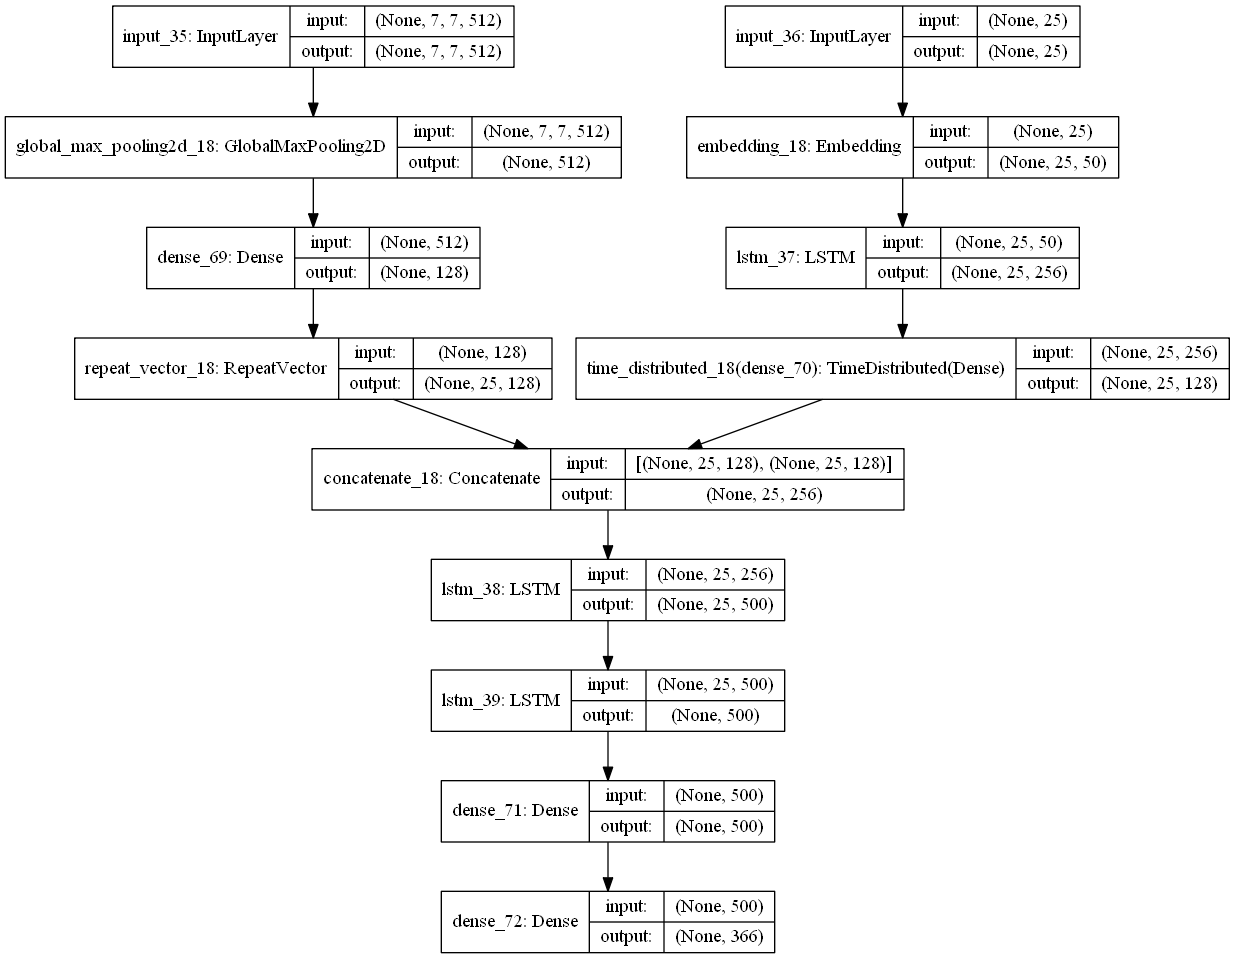

In [48]:
# define the captioning model
def define_model(vocab_size, max_length):
    # feature extractor (encoder)
    inputs1 = Input(shape=(7, 7, 512))
    fe1 = GlobalMaxPooling2D()(inputs1)
    fe2 = Dense(128, activation='relu')(fe1)
    fe3 = RepeatVector(max_length)(fe2)
    # embedding
    inputs2 = Input(shape=(max_length,))
    emb2 = Embedding(vocab_size, 50, mask_zero=True)(inputs2)
    emb3 = LSTM(256, return_sequences=True)(emb2)
    emb4 = TimeDistributed(Dense(128, activation='relu'))(emb3)
    # merge inputs
    merged = concatenate([fe3, emb4])
    # language model (decoder)
    lm2 = LSTM(500, return_sequences=True)(merged)
    lm3 = LSTM(500)(lm2)
    lm4 = Dense(500, activation='relu')(lm3)
    outputs = Dense(vocab_size, activation='softmax')(lm4)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    plot_model(model, show_shapes=True, to_file='size_lg_lang_model_plot.png')

    plot_modeln model
    
    
model_name = 'size_lg_lang_model'
model = define_model(vocab_size, max_length)
Image('size_lg_lang_model_plot.png')

In [49]:
train_results, test_results = run_experiment()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           (None, 25)           0                                            
__________________________________________________________________________________________________
global_max_pooling2d_19 (Global (None, 512)          0           input_37[0][0]                   
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 25, 50)       18300       input_38[0][0]                   
__________________________________________________________________________________________________
dense_73 (

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


>1: train=0.0837796241758185 test=0.06576483906020976


In [50]:
save_res(train_results, test_results)

         train      test
count  1.00000  1.000000
mean   0.08378  0.065765
std        NaN       NaN
min    0.08378  0.065765
25%    0.08378  0.065765
50%    0.08378  0.065765
75%    0.08378  0.065765
max    0.08378  0.065765


In [51]:
trainset_score = evaluate_and_print(model, train_descriptions, train_features, tokenizer, max_length)
trainset_score

Actual:    startseq child and woman are at waters edge in big city endseq
Predicted: startseq playground playground playground playground playground playground playground playground playground playground playground playground playground playground playground playground playground playground playground caches caches caches caches caches caches

Actual:    startseq boy with stick kneeling in front of goalie net endseq
Predicted: startseq racer riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding riding

Actual:    startseq woman crouches near three dogs in field endseq
Predicted: startseq bikes guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy guy

Actual:    startseq boy bites hard into treat while he sits outside endseq
Predicted: startseq bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bikes bike

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474

In [52]:
testset_score = evaluate_and_print(model, test_descriptions, test_features, tokenizer, max_length)
testset_score

Actual:    startseq couple with young child wrapped in blanket sitting on concrete step endseq
Predicted: startseq throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing throwing

Actual:    startseq adults and children stand and play in front of steps near wooded area endseq
Predicted: startseq bath camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage camouflage

Actual:    startseq boy in grey pajamas is jumping on the couch endseq
Predicted: startseq runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs runs long long long long

Actual:    startseq boy holding kitchen utensils and ma

C:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.4428500142691474


---
Again, we see minor movements in BLEU, perhaps an artifact of noise and dataset size. 

The improvement on the test dataset may be a good sign. This might be a change worth exploring.

Tuning model size on a much smaller dataset is challenging.

# Dataset copyright

Please cite M. Hodosh, P. Young and J. Hockenmaier (2013) "Framing Image Description as a Ranking Task: Data, Models and Evaluation Metrics", Journal of Artificial Intelligence Research, Volume 47, pages 853-899 http://www.jair.org/papers/paper3994.html when discussing our results

## Reference

https://machinelearningmastery.com/develop-a-caption-generation-model-in-keras/